In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
def imshowCV(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if(show):
        plt.show()
    
def imshow(img, axis = False, colorbar = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    if(colorbar):
        plt.colorbar()
    if(show):
        plt.show()
    
def torch2Img(img, show = True):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_img = to_np(img)
    if len(disp_img.shape) == 4:
        disp_img = disp_img[0]
    disp_img = disp_img.transpose((1,2,0))
    disp_img = disp_img * std + mean
    return disp_img
    
def imshowTorch(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    disp_img = torch2Img(img)
    plt.imshow(disp_img.astype(np.uint8))
    if(show):
        plt.show()

def plotImageScatter(img, choose, show = True):
    coords = np.unravel_index(choose, img.shape[:2])    
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))    
    plt.scatter(coords[1], coords[0], 50)
    #plt.colorbar()
    if(show):
        plt.show()

In [17]:
from quat_math import quat2AxisAngle

def quats2Point(quats):
    pts = []
    for q in quats:
        xi, theta = quat2AxisAngle(q)
        pts.append(xi*theta)
    return np.array(pts)

def scatterSO3(vertices, vals, q_gt = None, alpha_max = 1.0):
    #c = cmap(vals)
    a = np.maximum(0,np.minimum(1, (vals - min(vals))/(max(vals) - min(vals))))
    c = cmap(a)
    
    c[:,3] = alpha_max*a

    pts = quats2Point(vertices)
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=a*10, c=c)

    if(q_gt is not None):
        pt_gt = quats2Point(q_gt)
        ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='r', marker='x')

In [64]:
from transforms3d.quaternions import quat2mat, mat2quat

def getPoseCNNQuat(data, obj):
    pose_idx = np.where(data['rois'][:,1].flatten()==obj)[0]
    if(len(pose_idx) == 0):
        return None
    else:
        pose_idx = pose_idx[0]
    pose = data['poses'][pose_idx]
    q = pose[:4][[1,2,3,0]]
    q /= np.linalg.norm(q)
    t = pose[4:7]
    return q


In [4]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.feature_dataset import FeatureDataset

from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.IMAGE_CROPPED, 
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]



In [5]:
test_feature_root = '/scratch/bokorn/results/dense_fusion_local_feat_test/'
feature_root = '/scratch/bokorn/results/dense_fusion_local_orig_feat/'
feature_key = 'feat_global'

comp_model_checkpoint = '/scratch/bokorn/results/multi_object/df_local_global/trainval_lr_1e-5_top_x2000/2019-07-03_11-34-46/all/weights/checkpoint_31000.pth'
feature_size = 1024

In [6]:
feature_root = '/scratch/bokorn/results/posecnn_feat_all/'
test_feature_root = feature_root
feature_key = 'fc6'

comp_model_checkpoint = '/scratch/bokorn/results/multi_object/pcnn_fc6/trainval_lr_1e-6_top_x2000/2019-07-04_01-06-36/all/weights/checkpoint_44000.pth'
feature_size = 4096

In [29]:
from se3_distributions.models.compare_networks import SigmoidCompareNet

estimator_comp = SigmoidCompareNet(feature_size, 21)
estimator_comp.load_state_dict(torch.load(comp_model_checkpoint))
estimator_comp.cuda();

from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from object_pose_utils.utils.bingham import isobingham_likelihood
tetra_interp = TetraInterpolation(2)


In [ ]:
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift


import scipy.io as scio
from tqdm import tqdm_notebook as tqdm

grid_size = 3885
rep_indices = np.repeat(np.arange(1), grid_size)

err_compare = {}
err_bing = {}

lik_compare = {}
lik_bing = {}

with torch.no_grad():
    for object_id in tqdm(object_list):
        sym_axis, sym_ang = getYCBSymmeties(object_id)
        ycb_dataset = FeatureDataset(dataset_root = dataset_root,
                                     feature_root = test_feature_root,
                                     feature_key = feature_key,
                                     resample_on_error = False,
                                     mode=mode, object_list = [object_id])
        grid_vertices = torch.load(os.path.join(feature_root, 'grid',
            '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))
        grid_features = torch.load(os.path.join(feature_root, 'grid',
            '{}_{}_features.pt'.format(feature_key,ycb_dataset.classes[object_id])))

        grid_size = grid_vertices.shape[0]
        grid_features = to_var(grid_features)
        rep_indices = np.repeat(np.arange(1), grid_size)
        
        lik_compare[object_id] = []
        err_compare[object_id] = []
        lik_bing[object_id] = []
        err_bing[object_id] = []
        
        for j, data in tqdm(enumerate(ycb_dataset), total=len(ycb_dataset)):
            obj, feat, quat = data
            feature_data = np.load('{}/data/{}_{}_feat.npz'.format(ycb_dataset.feature_root, 
                ycb_dataset.getPath(j), ycb_dataset.classes[obj]))

            idx = torch.autograd.Variable(obj - 1).unsqueeze(0).cuda()
            feat = to_var(feat).unsqueeze(0)

            dist_est = estimator_comp(grid_features, feat[rep_indices])
            dist_est = torch.gather(dist_est, 1, idx[rep_indices])
            tetra_interp.setValues(to_np(dist_est.flatten()))
            lik_compare[object_id].append(tetra_interp.smooth(to_np(quat)).item())
            
            pcnn_mat = scio.loadmat('{}/data/{}-posecnn.mat'.format(ycb_dataset.dataset_root, ycb_dataset.getPath(j)))
            pcnn_quat = torch.tensor(getPoseCNNQuat(pcnn_mat, obj.item())).float()
            lik_bing[object_id].append(isobingham_likelihood(pcnn_quat.cuda(), 
                                torch.tensor(sigmas[obj.item()]).unsqueeze(0).float().cuda(),
                                quat.unsqueeze(0).cuda()).item()*2)
            
            mode_quat = grid_vertices[torch.argmax(dist_est)].unsqueeze(0)
            
            #v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_est.cuda(),
            #                    sigma=np.pi/9, max_iter = 100)
            
            err_compare[object_id].append(symmetricAngularDistance(mode_quat, quat.unsqueeze(0),
                                             sym_axis, sym_ang).item()*180/np.pi)
            
            err_bing[object_id].append(symmetricAngularDistance(pcnn_quat.unsqueeze(0), quat.unsqueeze(0),
                                           sym_axis, sym_ang).item()*180/np.pi)
            

In [149]:
print(lik_compare)
print(lik_bing)

{13: [array([0.09569893]), array([0.08297394]), array([0.10162026]), array([0.14188951]), array([0.0925106]), array([0.06267675]), array([0.05922071]), array([0.12155959]), array([0.06241314]), array([0.09934188]), array([0.10653224]), array([0.17637976]), array([0.20751009]), array([0.25051836]), array([0.23754817]), array([0.19345548]), array([0.20682849]), array([0.14856962]), array([0.14845107]), array([0.2610443]), array([0.14810441]), array([0.20124168]), array([0.24592652]), array([0.20184983]), array([0.20506513]), array([0.18204194]), array([0.27469466]), array([0.20778317]), array([0.18844802]), array([0.23414725]), array([0.15316415]), array([0.32581183]), array([0.27809613]), array([0.17255264]), array([0.17761308]), array([0.16060452]), array([0.16156638]), array([0.14658613]), array([0.23347664]), array([0.1286512]), array([0.20822262]), array([0.23714074]), array([0.07544814]), array([0.2482399]), array([0.12848136]), array([0.17437426]), array([0.18996219]), array([0.12

In [93]:

bing_interp = BinghamInterpolation(torch.tensor(pcnn_quat).unsqueeze(0), torch.tensor([1.]), 
                                   sigma=sigmas[obj.item()])

In [111]:
bing_interp(quat.unsqueeze(0).cuda())

tensor([0.0854], device='cuda:0')

tensor([[0.0854]], device='cuda:0')

In [107]:
sigma = torch.tensor(sigmas[obj.item()]).unsqueeze(0).float()
torch.cat([torch.zeros(1).float(),-sigma, -sigma, -sigma])

tensor([ 0.0000, -0.6633, -0.6633, -0.6633])

In [79]:
tetra_interp.setValues(to_np(dist_est.flatten()))
lik = tetra_interp.smooth(to_np(quat))
print(lik)

[0.13604579]


In [68]:
print(pcnn_quat)
print(quat)

[-0.5019051   0.09629406 -0.03618243 -0.8587838 ]
tensor([-0.1788, -0.3948, -0.8702,  0.2345])


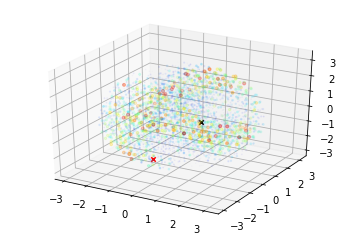

In [96]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap('jet')
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

scatterSO3(to_np(grid_vertices), to_np(dist_est.flatten()), [to_np(quat)], alpha_max = .5)
pt_gt = quats2Point([pcnn_quat])
ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='K', marker='x')

In [22]:
to_np(quat)
#quats2Point(to_np(quat)[0])
#to_np(dist_est)

array([ 0.30252334,  0.4792338 ,  0.6599504 , -0.49323422], dtype=float32)

In [12]:
torch.tensor(feature_data[ycb_dataset.feature_key])
torch.tensor(feature_data['quat'])


tensor([ 0.3025,  0.4792,  0.6600, -0.4932], dtype=torch.float64)